Jupyter notebook for EDA of data sets provided for a 2012 Global Energy Forecasting Competition on Kaggle. Competition link [here](https://www.kaggle.com/c/global-energy-forecasting-competition-2012-load-forecasting) and additional paper by competition host in International Journal of Forecasting [here](https://www.sciencedirect.com/science/article/pii/S0169207013000745). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 500)

## 1. Understanding objective and the datasets
The following description is from the competition link:
Data (loads of 20 zones and temperature of 11 stations) history ranges from the 1st hour of 2004/1/1 to the 6th hour of 2008/6/30.

Given actual temperature history, the 8 weeks below in the load history are set to be missing and are required to be backcasted. It's OK to use the entire history to backcast these 8 weeks.

2005/3/6 - 2005/3/12;<br>
2005/6/20 - 2005/6/26;<br>
2005/9/10 - 2005/9/16;<br>
2005/12/25 - 2005/12/31;<br>
2006/2/13 - 2006/2/19;<br>
2006/5/25 - 2006/5/31;<br>
2006/8/2 - 2006/8/8;<br>
2006/11/22 - 2006/11/28;<br>

In addition, the particpants need to forecast hourly loads from 2008/7/1 to 2008/7/7. No actual temperatures are given for this week. 

In [2]:
load_df = pd.read_csv("Data/Load_history.csv", thousands=",")
temp_df = pd.read_csv("Data/temperature_history.csv")

In [3]:
load_df.head()

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,16853.0,16450.0,16517.0,16873.0,17064.0,17727.0,18574.0,19355.0,19534.0,18611.0,17666.0,16374.0,15106.0,14455.0,13518.0,13138.0,14130.0,16809.0,18150.0,18235.0,17925.0,16904.0,16162.0,14750.0
1,1,2004,1,2,14155.0,14038.0,14019.0,14489.0,14920.0,16072.0,17800.0,19089.0,19577.0,20047.0,19770.0,18564.0,18137.0,17046.0,16127.0,15448.0,15839.0,17727.0,18895.0,18650.0,18443.0,17580.0,16467.0,15258.0
2,1,2004,1,3,14439.0,14272.0,14109.0,14081.0,14775.0,15491.0,16536.0,18197.0,19109.0,18012.0,17200.0,15950.0,14978.0,14162.0,13507.0,13414.0,13826.0,15825.0,16996.0,16394.0,15406.0,14278.0,13315.0,12424.0
3,1,2004,1,4,11273.0,10415.0,9943.0,9859.0,9881.0,10248.0,11016.0,12780.0,15108.0,15680.0,15280.0,14605.0,14689.0,14642.0,14207.0,13614.0,14162.0,16237.0,17430.0,17218.0,16633.0,15238.0,13580.0,11727.0
4,1,2004,1,5,10750.0,10321.0,10107.0,10065.0,10419.0,12101.0,14847.0,15259.0,14045.0,14009.0,14332.0,13908.0,13981.0,13865.0,13845.0,14350.0,15501.0,17307.0,18786.0,19089.0,19192.0,18416.0,17006.0,16018.0


In [4]:
temp_df.head()

,station_id,year,month,day,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,46,46,45,41,39,35,33.0,33.0,36.0,47.0,53.0,54.0,55.0,55.0,55.0,55.0,52.0,46.0,40.0,40.0,39.0,38.0,40.0,41.0
1,1,2004,1,2,43,44,46,46,47,47,47.0,47.0,47.0,47.0,47.0,49.0,52.0,56.0,54.0,56.0,57.0,53.0,50.0,47.0,46.0,45.0,45.0,45.0
2,1,2004,1,3,45,46,46,44,43,46,46.0,47.0,51.0,55.0,56.0,59.0,65.0,68.0,69.0,68.0,68.0,65.0,64.0,63.0,62.0,63.0,63.0,62.0
3,1,2004,1,4,63,62,62,62,60,60,60.0,62.0,60.0,64.0,64.0,66.0,71.0,70.0,71.0,72.0,71.0,68.0,67.0,67.0,65.0,64.0,65.0,64.0
4,1,2004,1,5,64,63,65,64,64,64,64.0,64.0,65.0,66.0,66.0,67.0,68.0,68.0,66.0,66.0,66.0,66.0,63.0,54.0,52.0,49.0,47.0,47.0


We see that the 11 station_ids in the temperature history do not correspond to the 20 zone_ids in the load history, and we will need an algorithm to select stations representing a zone if we seek to use temperature data. 

In [5]:
load_df[load_df.isna().any(axis=1)]

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
430,1,2005,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,1,2005,3,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
432,1,2005,3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,1,2005,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
434,1,2005,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
435,1,2005,3,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
436,1,2005,3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536,1,2005,6,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,1,2005,6,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,1,2005,6,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We note that the NaN values in load correspond to the dates that we must backcast and forecast. We will store these in a separate dataframe and drop them from load_df.

In [6]:
load_to_pred_df = load_df[load_df.isna().any(axis=1)]
load_df = load_df.dropna()

In [7]:
temp_df[temp_df.isna().any(axis=1)]

,station_id,year,month,day,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
1642,1,2008,6,30,74,74,74,74,74,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3285,2,2008,6,30,66,65,64,64,64,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4928,3,2008,6,30,77,76,76,75,75,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6571,4,2008,6,30,72,72,72,72,72,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8214,5,2008,6,30,73,74,74,73,72,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9857,6,2008,6,30,70,70,70,70,70,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11500,7,2008,6,30,74,73,72,71,71,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13143,8,2008,6,30,72,71,71,71,70,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14786,9,2008,6,30,75,72,72,69,69,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16429,10,2008,6,30,70,70,70,70,70,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There also appear to be missing values in temp_df a couple hours before thee dates we need to forecast. We will get back to this later, as we want to first predict loads solely off historical load data.

We will also add a date column to all the dataframes using the year, month, and day columns provided

In [8]:
load_df['date'] = pd.to_datetime(load_df[['year', 'month', 'day']])
load_to_pred_df['date'] = pd.to_datetime(load_to_pred_df[['year', 'month', 'day']])
temp_df['date'] = pd.to_datetime(temp_df[['year', 'month', 'day']])

## 2. Load data
### a) EDA
In this part, we seek to better understand load data and if we can use historical load data to backcast and forecast the missing values. We first add a daily load column, which will be helpful later on.

In [9]:
load_df['daily_load'] = load_df.drop(['year', 'month', 'day', 'date'], axis=1).sum(axis=1)

We first examine how the load varies over the months of the year, expecting that we may see greater energy demand in winter months for heating and summer months for cooling. From the plot below, we see that the load varies drastically across different zones. Furthermore, some exhibit sinusoidal behavior relative to the month of year as expected. 

Text(0.5, 1.0, 'Average daily load per month')

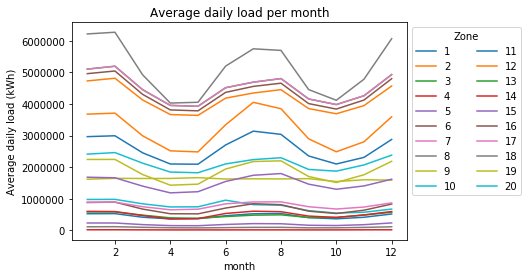

In [10]:
daily_load_by_month = (load_df.groupby(['month', 'zone_id'])['daily_load']
                       .mean().reset_index())
ax = daily_load_by_month.pivot_table(values='daily_load', index='month', columns='zone_id').plot()
ax.set_ylabel('Average daily load (kWh)')
ax.legend(title='Zone', loc=0, ncol=2, bbox_to_anchor=(1,1))
ax.set_title('Average daily load per month')

We then plot the data for each zone individually to see if the monthly pattern exists for all zones. We notice that zone 9 does not appear to be a function of the month of year as shown below.

Text(0.5, 1.0, 'Zone 9 daily load')

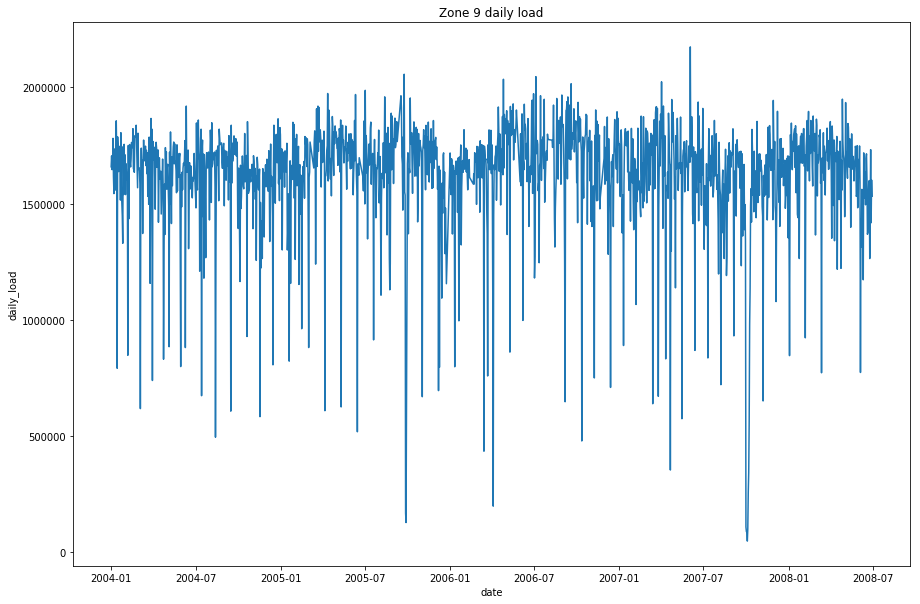

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
ax = sns.lineplot(x='date', y='daily_load' ,data=load_df.where(load_df['zone_id']==9))
ax.set_title('Zone 9 daily load')

Furthermore, we observe what appears to be a discontinuity in load occuring in January 2008 for zone 10.

Text(0.5, 1.0, 'Zone 10 daily load')

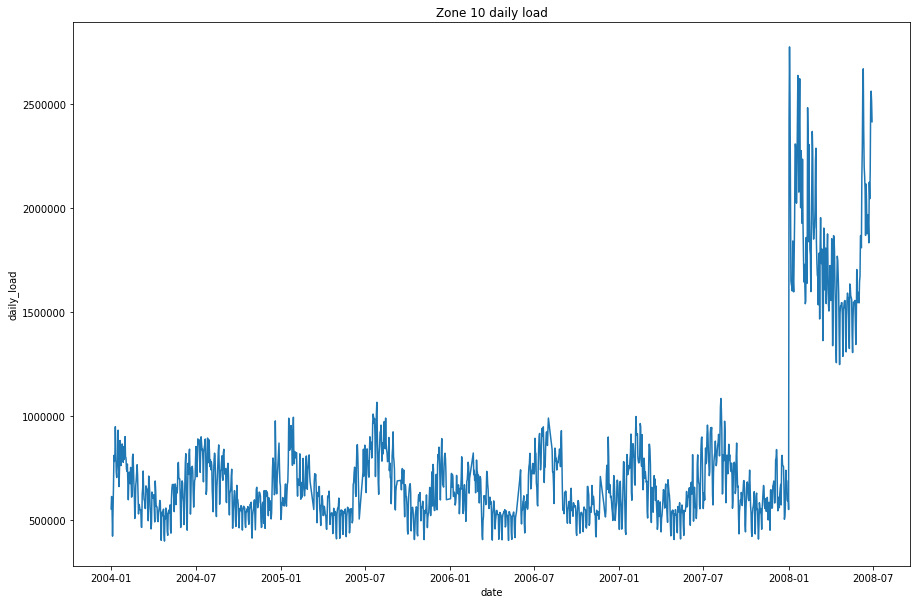

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
ax = sns.lineplot(x='date', y='daily_load' ,data=load_df.where(load_df['zone_id']==10))
ax.set_title('Zone 10 daily load')

Noticing this significant increase in load in 2008 for zone 10, we then seek to observe how has loads have changed over the years (as we seek to backcast and forecast later on). In general we do see a slight increase for most zones (with only zone 10 nearly quadrupling in load).

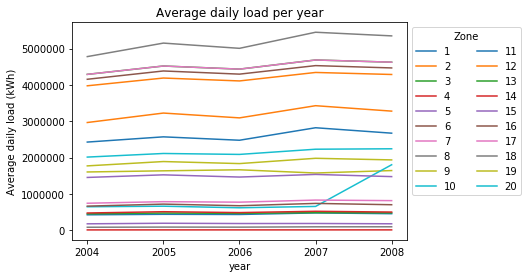

In [13]:
daily_load_by_year = (load_df.groupby(['year', 'zone_id'])['daily_load']
                       .mean().reset_index())
ax = daily_load_by_year.pivot_table(values='daily_load', index='year', columns='zone_id').plot()
ax.set_ylabel('Average daily load (kWh)')
ax.legend(title='Zone', loc=0, ncol=2, bbox_to_anchor=(1,1))
ax.set_title('Average daily load per year')
ax.set_xticks(ticks=np.arange(2004, 2008.5, 1))

We next want to see if the load varies with the day of the week so we add a weekday column. By default in datetime, "0" represents Monday. The zones don't follow a single pattern - some see elevated loads during the weekends while others see elevated loads during the weekday. To illustrate this point, the averagee daily loads of the first 4 zones have been plotted. We see a decrease in load on Saturday and Sunday in zones 2 and 3, but an iincrease in load on the same days for zone 4.

In [40]:
load_df['weekday'] = load_df['date'].dt.weekday

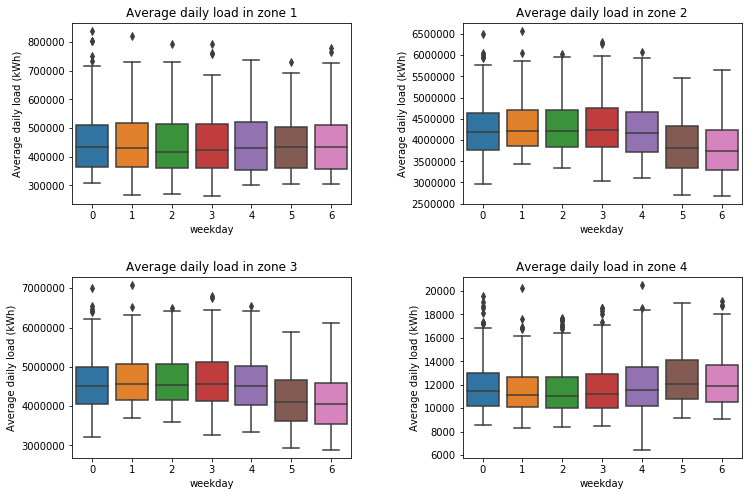

In [75]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
sns.boxplot(x='weekday', y='daily_load', data=load_df[load_df['zone_id']==1], ax=ax1)
ax1.set_ylabel('Average daily load (kWh)')
ax1.set_title('Average daily load in zone 1')
sns.boxplot(x='weekday', y='daily_load', data=load_df[load_df['zone_id']==2], ax=ax2)
ax2.set_ylabel('Average daily load (kWh)')
ax2.set_title('Average daily load in zone 2')
sns.boxplot(x='weekday', y='daily_load', data=load_df[load_df['zone_id']==3], ax=ax3)
ax3.set_ylabel('Average daily load (kWh)')
ax3.set_title('Average daily load in zone 3')
sns.boxplot(x='weekday', y='daily_load', data=load_df[load_df['zone_id']==4], ax=ax4)
ax4.set_ylabel('Average daily load (kWh)')
ax4.set_title('Average daily load in zone 4')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

We next want to see if the hour of the day affects load, which requires us to pivot the hour columns in the dataframe. After plotting the average hourly loads (below we show 4 zones), we see that load is typically highest during the day and drops during the night. Again, zone 9 exhibits a different behavior than other zones (peaking at night). 

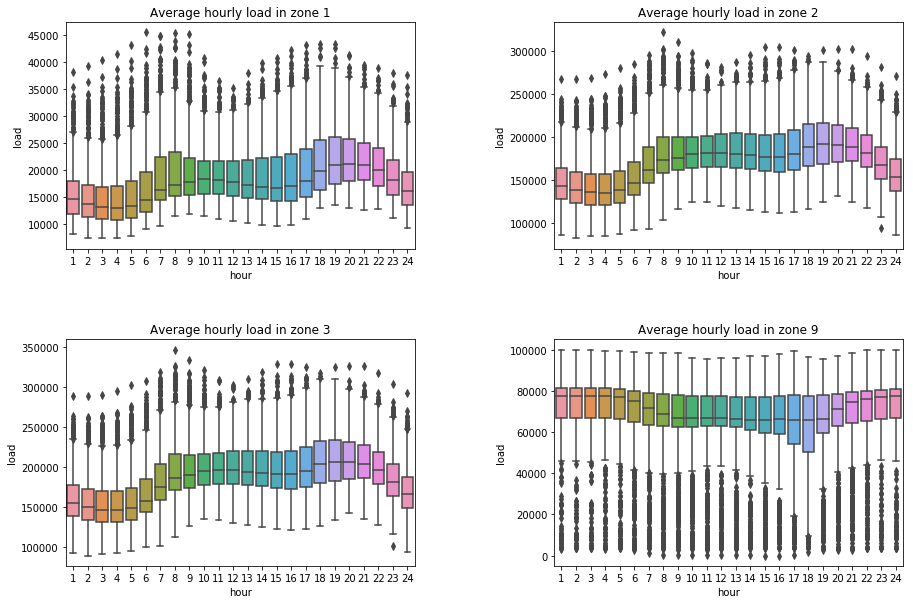

In [101]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
hourly_load = (load_df.drop(['date', 'daily_load', 'year', 'month', 'day', 'weekday'], axis=1)
               .melt(id_vars=['zone_id'], var_name='hour', value_name='load'))
sns.boxplot(x='hour', y='load', data=hourly_load[hourly_load['zone_id']==1], ax=ax1)
ax1.set_xticklabels(range(1, 25))
ax1.set_title('Average hourly load in zone 1')
sns.boxplot(x='hour', y='load', data=hourly_load[hourly_load['zone_id']==2], ax=ax2)
ax2.set_xticklabels(range(1, 25))
ax2.set_title('Average hourly load in zone 2')
sns.boxplot(x='hour', y='load', data=hourly_load[hourly_load['zone_id']==3], ax=ax3)
ax3.set_xticklabels(range(1, 25))
ax3.set_title('Average hourly load in zone 3')
sns.boxplot(x='hour', y='load', data=hourly_load[hourly_load['zone_id']==9], ax=ax4)
ax4.set_xticklabels(range(1, 25))
ax4.set_title('Average hourly load in zone 9')
plt.subplots_adjust(wspace=0.4, hspace=0.4)

### b) Multivariate linear regression from load data
From the trends we've noted above (zonal, yearly, monthly, hourly, etc.), we can build a simple linear regression model to predict loads. We will need to one-hot encode the zone, year, and month attributes. Additionally, we will standardize load data to better run regression with L1 or L2 regularization.

In [ ]:
def process_data(data, test=False):
    X = (
        data
        
        # Transform data
        .pipe(add_time_columns)
        .pipe(add_distance_columns)
        
        .pipe(select_columns,        
              'pickup_longitude',  
              'pickup_latitude',   
              'dropoff_longitude', 
              'dropoff_latitude',
              'manhattan',
             )
    )
    if test:
        y = None
    else:
        y = data['duration']
        
    return X, y